# Inpirasi
1. https://www.kaggle.com/code/snopoff/riemannian-low-rank-matrix-completion
2. https://www.kaggle.com/code/yashaswiniv/starter-netflix-prize-data-900bd601-6
3. https://www.kaggle.com/code/utsav15/netflix-recommendation



# Import Libraries

In [1]:
import matplotlib.pyplot as plt

In [2]:
from gc import collect
from os import path
from functools import wraps
from warnings import filterwarnings
from time import time
from pandas import DataFrame,read_csv,plotting,Series
from numpy import issubdtype,number
from seaborn import heatmap

https://medium.com/@ariamada20/problem-install-scikit-surprise-f74892131f82

In [3]:
from surprise import Reader,Dataset,NormalPredictor,SVD,NMF,SlopeOne,CoClustering,accuracy
from surprise.model_selection import KFold,cross_validate,train_test_split,GridSearchCV
from surprise.accuracy import rmse

In [4]:
filterwarnings('ignore')

# Get Data For The First Time (DON'T RUN THIS)

In [6]:
def time_this(func): 
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time()
        result = func(*args, **kwargs)
        end = time()
        print("{} takes {} minutes!".format(func.__name__, round((end-start)/60, 2)))
        collect()
        return result 
    return wrapper

In [7]:
working_dir = './data/' 
data_files = [working_dir + 'combined_data_{}.txt'.format(i) for i in range(1,5)]
print('Data files to be combined and pre-processed: ')
print(data_files)

Data files to be combined and pre-processed: 
['./data/combined_data_1.txt', './data/combined_data_2.txt', './data/combined_data_3.txt', './data/combined_data_4.txt']


## Bersihkan Data

In [8]:
# Replace ":" yang terdapat di movie id dengan string kosong
get_movie_id = lambda line: int(line.replace(':', '').replace('\n', ''))
# Buang spasi kosong pada rating
get_rating = lambda line: [x.replace('\n', '') for x in line.split(',')]
df_it = lambda row: DataFrame(row, index=['cust_id', 'rating', 'date']).T

def append_to_csv(data, fp):
    print('Writing {} rows to {}'.format(data.shape[0], fp))
    if path.exists(fp):
        data.to_csv(fp, mode='a', index=False, header=False)
    else:
        data.to_csv(fp, index=False)

@time_this
def get_ratings(fp):
    """
    Parse the text files that have movie id and customer ratings into a usable dataframe.
    @fp: file path (str)
    """
    print('Getting ratings from file: {}'.format(fp))
    agg_data = []
    with open(fp, 'r') as file_:
        for line_number, line in enumerate(file_):
            if (line_number % 10**7) == 0: print('{} million rows..'.format(line_number / (10**6)))
            if ':' in line:
                movie_id = get_movie_id(line)                      
            else:
                rating_row = get_rating(line)
                rating = {str(col): val for col,val in enumerate(rating_row)}
                rating['movie_id'] = movie_id
                agg_data.append(rating)            
    agg_data = DataFrame(agg_data)
    agg_data.rename(columns={'0': 'cust_id', '1': 'rating', '2': 'date'}, inplace=True)
    print('Finished getting ratings from file: {}'.format(fp))
    return agg_data

In [9]:
df = get_ratings(data_files[0])
append_to_csv(df, 'ratings.csv')
del df
collect()

Getting ratings from file: ./data/combined_data_1.txt
0.0 million rows..
10.0 million rows..
20.0 million rows..
Finished getting ratings from file: ./data/combined_data_1.txt
get_ratings takes 4.97 minutes!
Writing 24053764 rows to ratings.csv


0

# Get Data After Processing

In [13]:
# Saya hanya meload 1 juta baris pertama
data = read_csv('./data/ratings.csv',nrows=1e5)
data

,cust_id,rating,date,movie_id
0,1488844,3,2005-09-06,1
1,822109,5,2005-05-13,1
2,885013,4,2005-10-19,1
3,30878,4,2005-12-26,1
4,823519,3,2004-05-03,1
...,...,...,...,...
99995,2146325,5,2004-04-29,30
99996,2103907,3,2004-07-14,30
99997,2581477,4,2005-08-27,30
99998,2182488,4,2004-08-21,30


In [14]:
def getDatasetShape(df):
    row,col = "{:,}".format(df.shape[0]),df.shape[1]
    return row,col

row,col = getDatasetShape(data)
print(f'Dataset Row = {row} Rows')
print(f'Dataset Columns = {col} Columns')

Dataset Row = 100,000 Rows
Dataset Columns = 4 Columns


# Data Visualization

In [15]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    # For displaying purposes, pick columns that have between 1 and 50 unique values
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] 
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not issubdtype(type(columnDf.iloc[0]), number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i+1})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

## Bar Graph

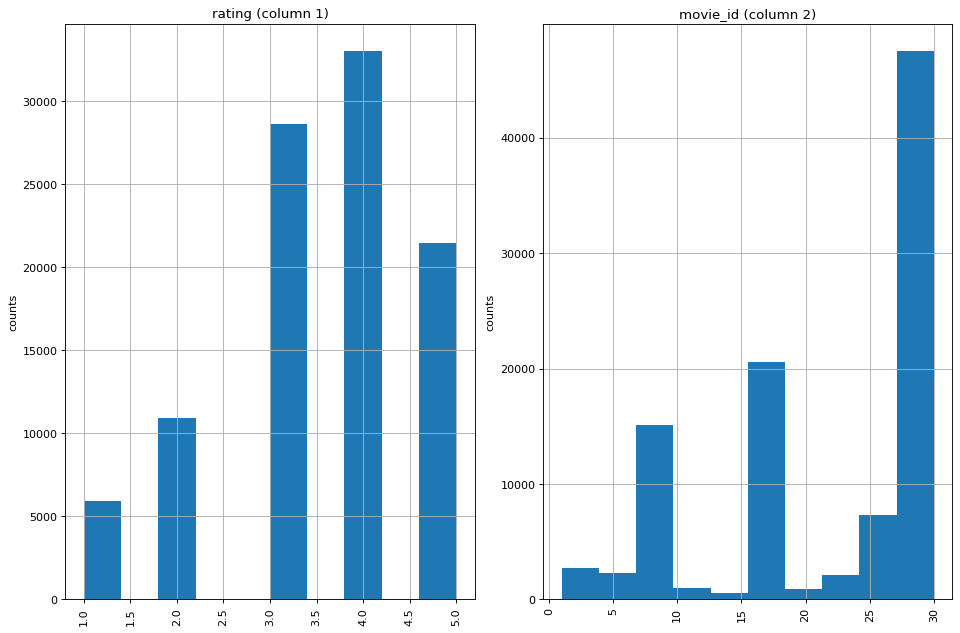

In [16]:
plotPerColumnDistribution(data, 10, 5)

## Correlation Matrix

In [17]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    # drop columns with NaN
    df = df.dropna('columns') 
     # keep columns where there are more than 1 unique values
    df = df[[col for col in df if df[col].nunique() > 1]]
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    heatmap(df.iloc[:,1:].corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
    plt.title(f'Correlation Matrix for Netflix Prize Data', fontsize=15)
    plt.show()

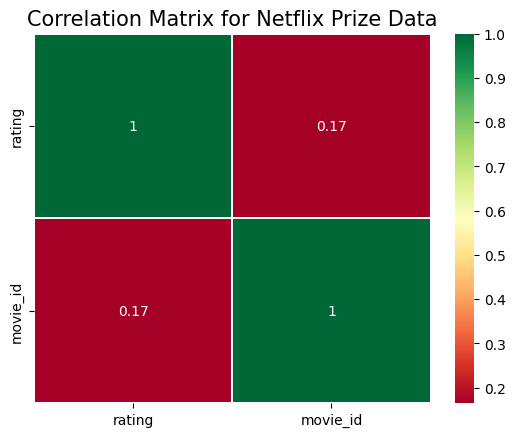

In [18]:
plotCorrelationMatrix(data, 8)

## Scatter Matrix (DON'T RUN THIS)

In [19]:
@time_this
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    # keep only numerical columns
    df = df.select_dtypes(include =[number]) 
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    # keep columns where there are more than 1 unique values
    df = df[[col for col in df if df[col].nunique() > 1]] 
    columnNames = list(df)
    # reduce the number of columns for matrix inversion of kernel density plots
    if len(columnNames) > 10: 
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

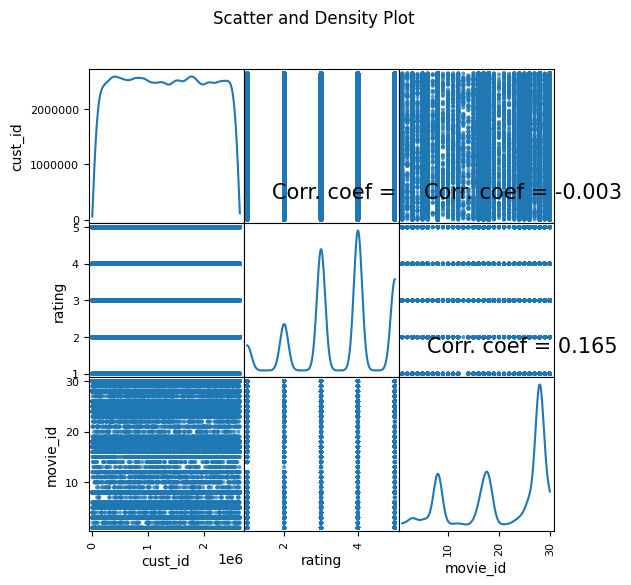

plotScatterMatrix takes 0.06 minutes!


In [20]:
plotScatterMatrix(data, 6, 15)

# Check Data

In [21]:
duplicate_data = data.duplicated().sum()
null_data = data.isnull().sum().sum()
print(f'Terdapat {duplicate_data} rows data duplikat')
print(f'Terdapat {null_data} rows data kosong')

Terdapat 0 rows data duplikat
Terdapat 0 rows data kosong


<p style="font-size:20px">Tidak terdapat baris yang duplikasi dan data kosong karena sudah di bersihkan ketika menggabungkan dataset</p>

# Matrix Factorization

In [22]:
ratings = data[['cust_id','movie_id','rating']]
ratings

,cust_id,movie_id,rating
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,30878,1,4
4,823519,1,3
...,...,...,...
99995,2146325,30,5
99996,2103907,30,3
99997,2581477,30,4
99998,2182488,30,4


In [23]:
ratings.groupby('cust_id')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,cust_id,rating
11842,387418,28
9313,305344,28
75073,2439493,27
51232,1664010,25
65252,2118461,25
59593,1932594,16
44999,1461435,16
63305,2056022,14
40515,1314869,14
43205,1403217,14


In [24]:
# Define the format
reader = Reader(line_format='user item rating timestamp', sep='\t')

reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(ratings[['cust_id', 'movie_id', 'rating']], reader)
data

In [25]:
%%time
data = Dataset.load_from_df(ratings[['cust_id', 'movie_id', 'rating']], reader)
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(n_epochs = 1, n_factors = 20),]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

CPU times: total: 109 ms
Wall time: 909 ms


In [26]:
surprise_results = DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.054089,0.052296,0.11117


## Hyperparameter Tuning (DON'T RUN'T THIS)

In [27]:
%%time
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv = 3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

1.043615745206947
{'n_factors': 35, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}
CPU times: total: 1min 7s
Wall time: 3min 7s


In [28]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.0433


1.043317778711905

In [29]:
predictions

[Prediction(uid=2127108, iid=25, r_ui=3.0, est=3.7801813462546217, details={'was_impossible': False}),
 Prediction(uid=1902220, iid=28, r_ui=5.0, est=3.7404881178139875, details={'was_impossible': False}),
 Prediction(uid=1120274, iid=28, r_ui=5.0, est=3.7404881178139875, details={'was_impossible': False}),
 Prediction(uid=901520, iid=16, r_ui=3.0, est=3.239726719284365, details={'was_impossible': False}),
 Prediction(uid=2332613, iid=28, r_ui=3.0, est=3.7404881178139875, details={'was_impossible': False}),
 Prediction(uid=610714, iid=30, r_ui=5.0, est=3.733379062980064, details={'was_impossible': False}),
 Prediction(uid=1755612, iid=28, r_ui=4.0, est=3.761212345468991, details={'was_impossible': False}),
 Prediction(uid=166382, iid=8, r_ui=4.0, est=3.20003566185169, details={'was_impossible': False}),
 Prediction(uid=2033567, iid=28, r_ui=4.0, est=3.7404881178139875, details={'was_impossible': False}),
 Prediction(uid=759655, iid=26, r_ui=4.0, est=2.915180377791374, details={'was_imp